In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *

### Simulation Settings + Define Operators

In [11]:
# Highest Fock state
nMax = 100

# Size of Wigner function to plot (set to match the plots from the paper)
xvec = np.linspace(-3, 3, 200)
pvec = np.linspace(-2, 3, 200)

# QuTip integration settings
options = Options()
options.num_cpus = 5
options.nsteps = 100000

# Define Operators
a = tensor(qeye(2), destroy(nMax))
x = tensor(qeye(2), position(nMax))

sX = tensor(sigmax(), qeye(nMax))
sY = tensor(sigmay(), qeye(nMax))
sZ = tensor(sigmaz(), qeye(nMax))
sM = tensor(destroy(2), qeye(nMax))

# Define Hamiltonians
rsb = a * sM.dag()
def rsb_coeff(t, args):
    return args['omega'] * np.exp(1j * args['rsb_phase']) * np.exp(-1j * args['rsb_detuning'] * t)

rsbp = a.dag() * sM 
def rsbp_coeff(t, args):
    return args['omega'] * np.exp(-1j * args['rsb_phase']) * np.exp(1j * args['rsb_detuning'] * t)

bsb = a.dag() * sM.dag()
def bsb_coeff(t, args):
    return args['omega'] * np.exp(1j * args['bsb_phase']) * np.exp(-1j * args['bsb_detuning'] * t)

bsbp = a * sM
def bsbp_coeff(t, args):
    return args['omega'] * np.exp(-1j * args['bsb_phase']) * np.exp(1j * args['bsb_detuning'] * t)

rsbH = [
    [rsb, rsb_coeff], [rsbp, rsbp_coeff]
]

bsbH = [
    [bsb, bsb_coeff], [bsbp, bsbp_coeff]
]

ion_displace = [
    [rsb, rsb_coeff], [rsbp, rsbp_coeff], [bsb, bsb_coeff], [bsbp, bsbp_coeff]
]

args = {"omega": 1, "rsb_detuning": 0, "bsb_detuning": 0, "rsb_phase": 0, "bsb_phase": 0}

Text(0, 0.5, 'Population')

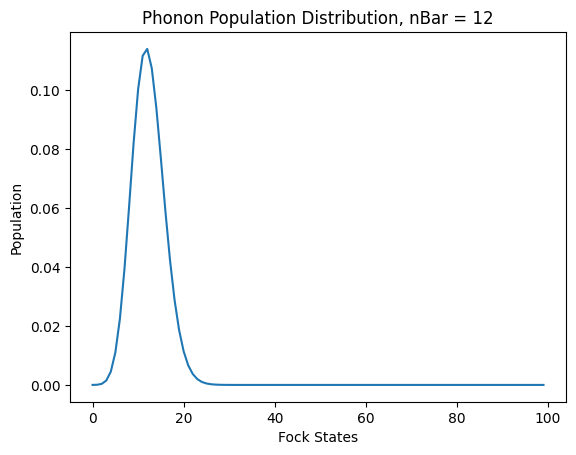

In [12]:
# Generate some highly displaced state

initial_qubit = basis(2, 0) + basis(2, 1)
initial_phonon = basis(nMax , 0)

rho0 = mesolve(H = ion_displace, rho0 = tensor(initial_qubit, initial_phonon), tlist = [0.0, 3.5], args = args, options = options).states[-1]
rho0_motion = ptrace(rho0, 1)

population = np.real(np.diag(rho0_motion))
nBar = np.sum([n * population[n] for n in range(nMax)])

plt.plot(population)
plt.title("Phonon Population Distribution, nBar = " + str(int(nBar)))
plt.xlabel("Fock States")
plt.ylabel("Population")


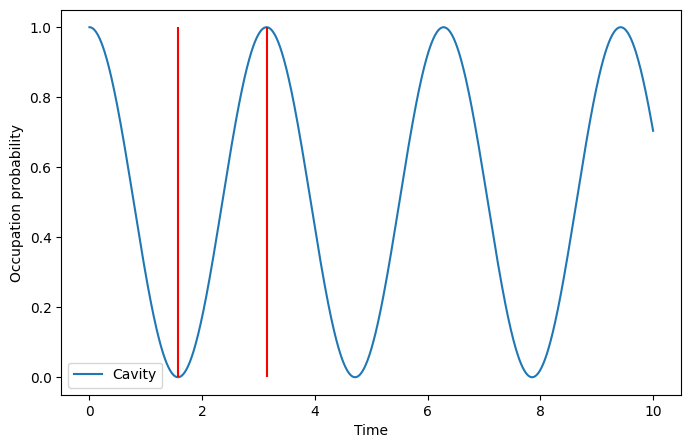

In [13]:
# Check Pi-time of RSB
tlist = np.linspace(0, 10, 1000)

initial_qubit = basis(2, 0)
initial_phonon = basis(nMax, 1)

output = mesolve(H = rsbH, rho0 = tensor(initial_qubit, initial_phonon), tlist = tlist, e_ops = [a.dag() * a], args = args, options = options)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tlist, output.expect[0], label="Cavity")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")

ax.vlines(np.pi/2, ymin = 0, ymax = 1, color = 'r')
ax.vlines(np.pi, ymin = 0, ymax = 1, color = 'r')

# So pi-time is Pi/2

In [14]:
rho = tensor(ket2dm(basis(2,0)), rho0_motion)

for i in range(100):
    rho = mesolve(H = rsbH, rho0 = rho, tlist = [0.0, np.pi/2], args = args, options = options).states[-1]
    rho_motion = ptrace(rho, 1)
    rho = tensor(ket2dm(basis(2,0)), rho_motion)

rho_motion = ptrace(rho, 1)
population = np.real(np.diag(rho_motion))
nBar = np.sum([n * population[n] for n in range(nMax)])

output = mesolve(H = bsbH, rho0 = rho, tlist = tlist, e_ops = [sM.dag() * sM], args = args, options = options)

Text(0, 0.5, 'Excited State Population')

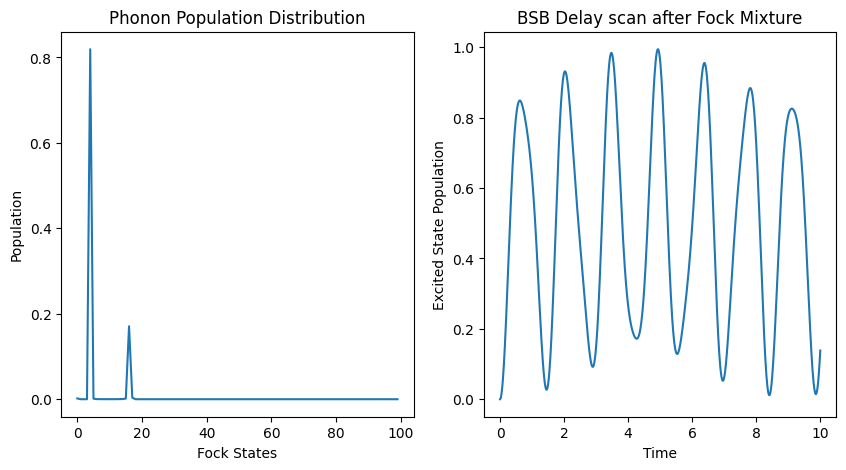

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(population)
ax[0].set_title("Phonon Population Distribution")
ax[0].set_xlabel("Fock States")
ax[0].set_ylabel("Population")

ax[1].plot(tlist, output.expect[0])
ax[1].set_title("BSB Delay scan after Fock Mixture")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Excited State Population")

# So this kind of works

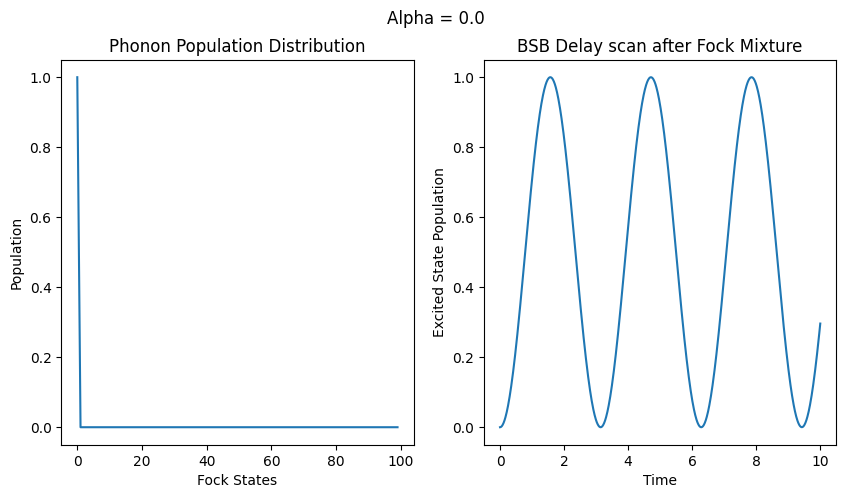

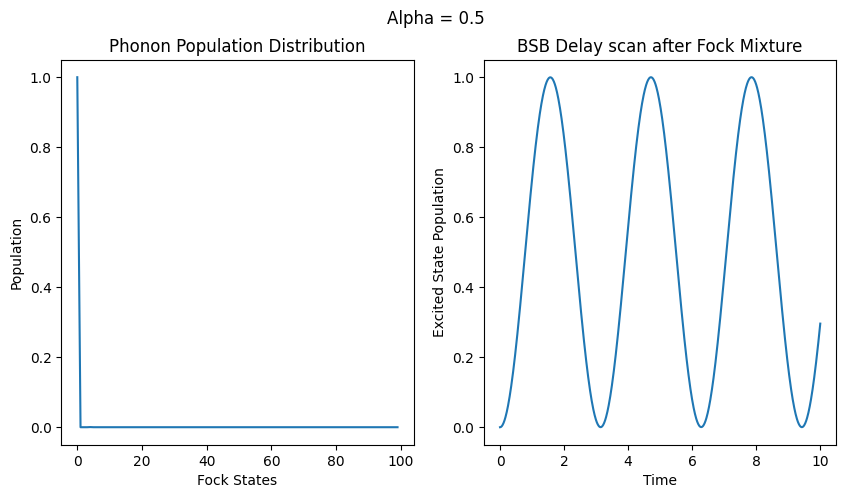

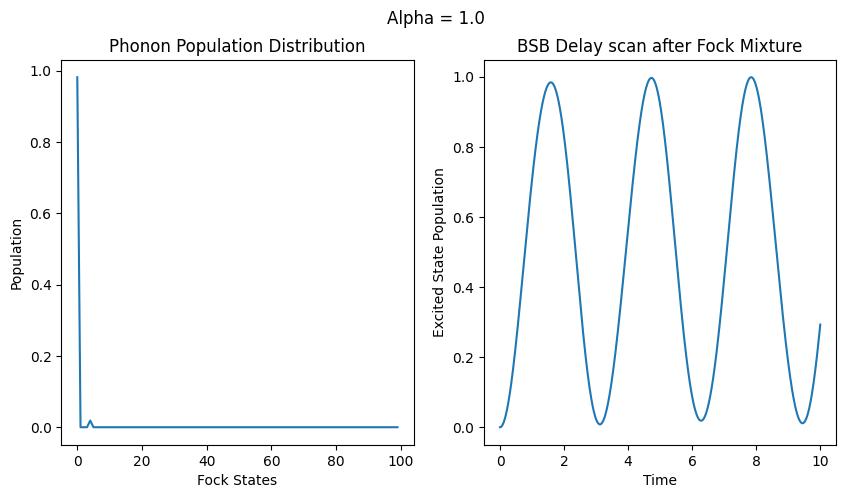

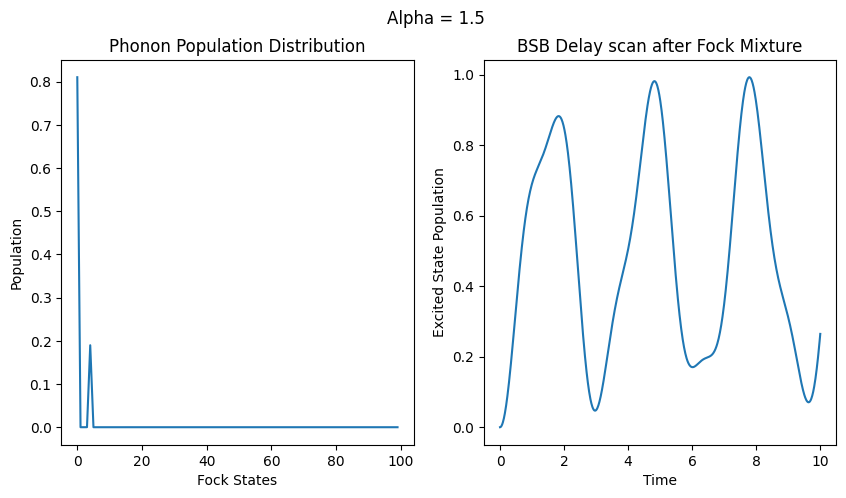

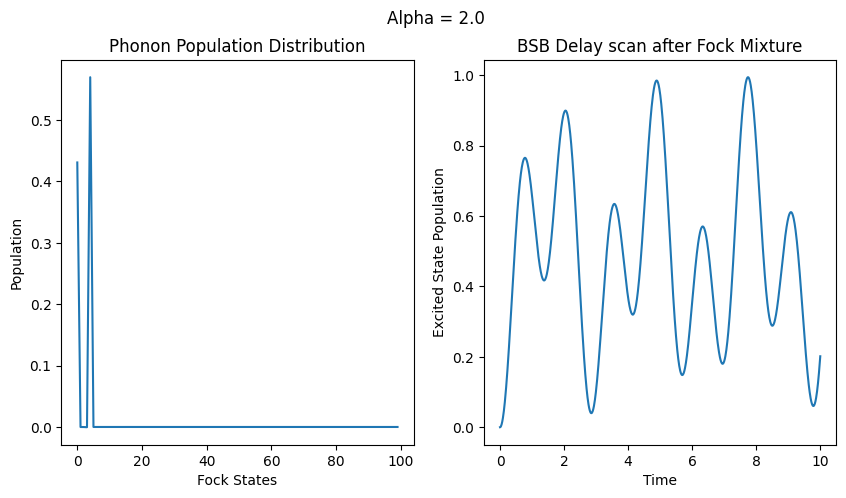

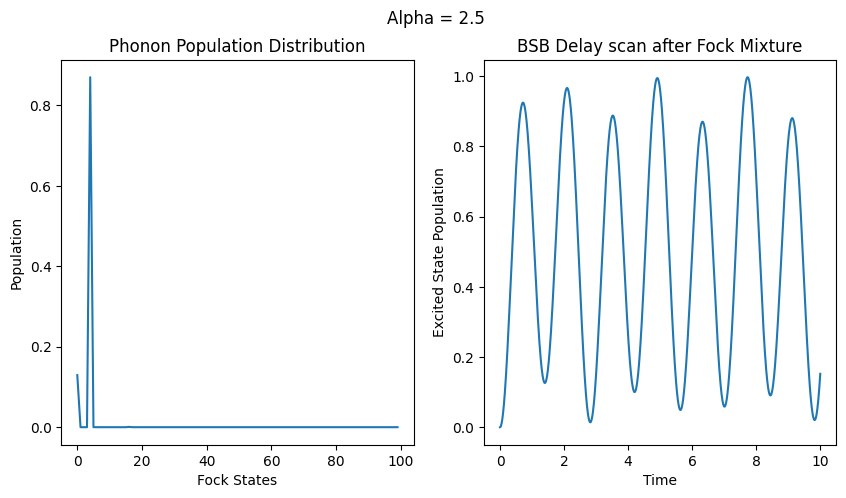

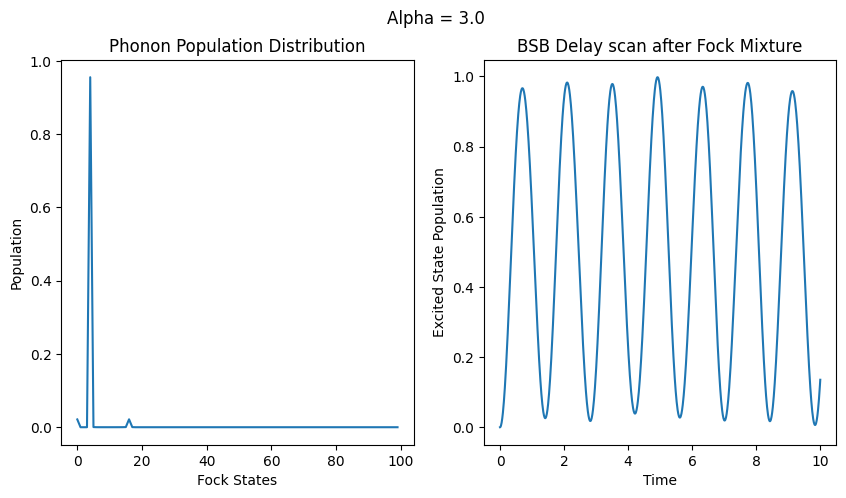

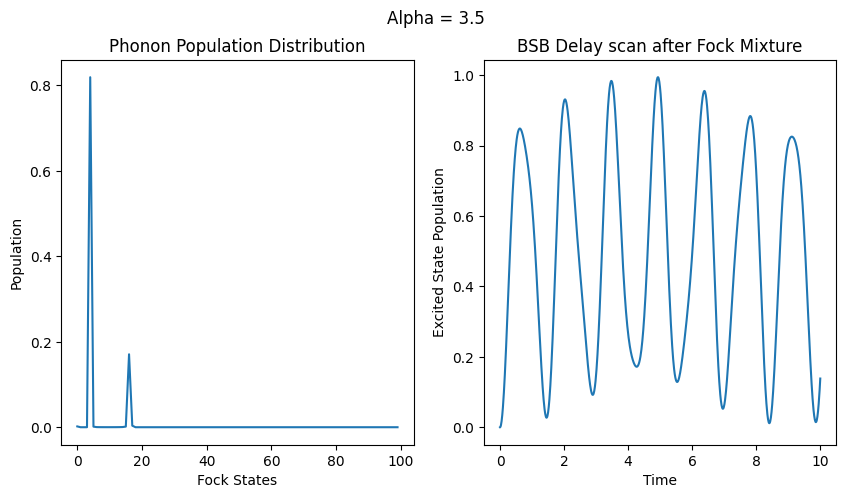

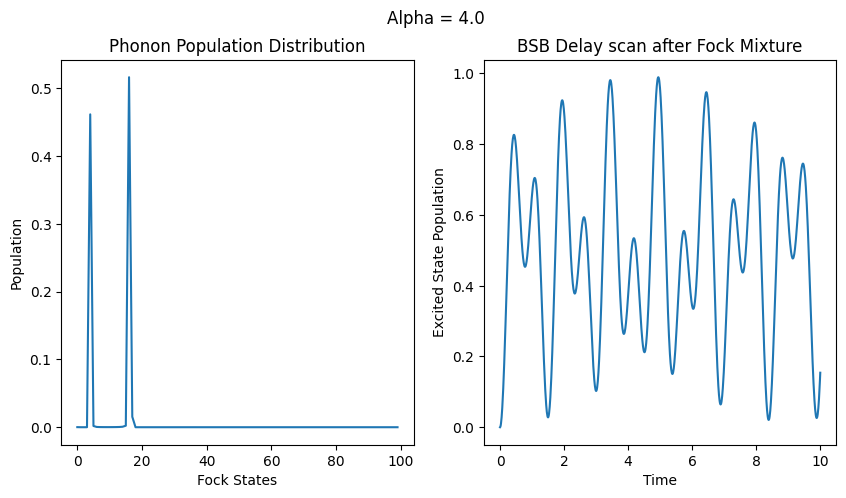

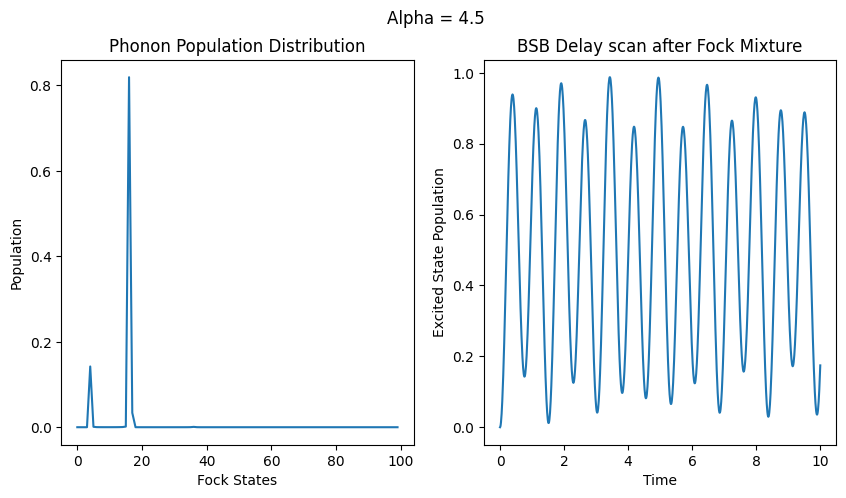

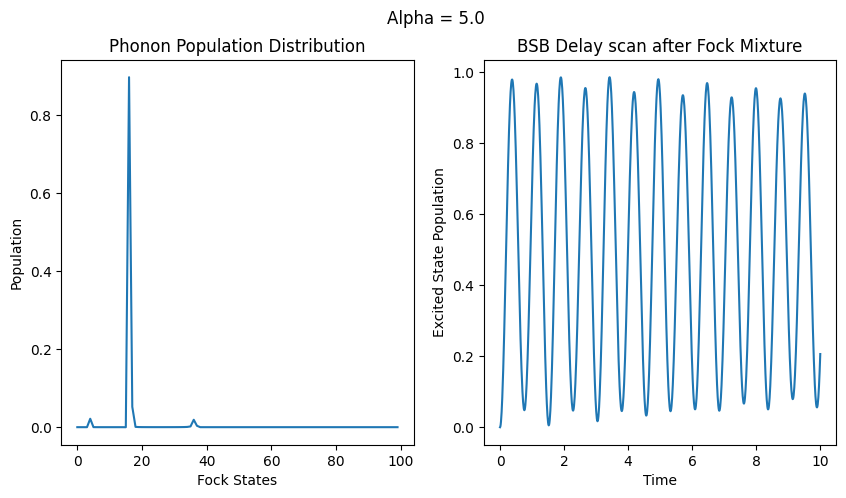

In [16]:
# Figure out how small of an amplitude change is detectable

alpha = [0.5 * i for i in range(11)]

for a in alpha:
    initial_qubit = basis(2, 0) + basis(2, 1)
    initial_phonon = basis(nMax , 0)

    rho0 = mesolve(H = ion_displace, rho0 = tensor(initial_qubit, initial_phonon), tlist = [0.0, a], args = args, options = options).states[-1]
    rho0_motion = ptrace(rho0, 1)

    rho = tensor(ket2dm(basis(2,0)), rho0_motion)

    for i in range(100):
        rho = mesolve(H = rsbH, rho0 = rho, tlist = [0.0, np.pi/2], args = args, options = options).states[-1]
        rho_motion = ptrace(rho, 1)
        rho = tensor(ket2dm(basis(2,0)), rho_motion)

    rho_motion = ptrace(rho, 1)
    population = np.real(np.diag(rho_motion))
    nBar = np.sum([n * population[n] for n in range(nMax)])

    output = mesolve(H = bsbH, rho0 = rho, tlist = tlist, e_ops = [sM.dag() * sM], args = args, options = options)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle("Alpha = " + str(np.round(a, 1)))
    ax[0].plot(population)
    ax[0].set_title("Phonon Population Distribution")
    ax[0].set_xlabel("Fock States")
    ax[0].set_ylabel("Population")

    ax[1].plot(tlist, output.expect[0])
    ax[1].set_title("BSB Delay scan after Fock Mixture")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Excited State Population")
    
    plt.show()